In [912]:
# import required libraries
import glob
import operator
import os
import random
import re
from functools import reduce
import lxml
import pandas as pd
import requests
from bs4 import BeautifulSoup
from LeXmo import LeXmo
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from pandas import DataFrame
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from tika import parser
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

In [17]:
# checking avaliable sites for scraping and getting response if HTTP response code permits

url_list = [
    "https://www.simplyscripts.com",
    "http://www.script-o-rama.com",
    "https://imsdb.com",
    "https://www.scriptslug.com",
]


def get_url_status_preview(url):
    response = requests.get(url)
    try:
        print("Checking site status code for:", str(url))

        print("Response recieved:", response.status_code)
        if response.status_code != 200:
            print("Site Unable to Authorize Request")
        else:
            soup = BeautifulSoup(response.content, "lxml")
            return soup
    except:
        print("Error: Check formatting of URL inputs/response request")


# create empty list and append with parsed html
url_info = []
for url in url_list:
    url_info.append(get_url_status(url))
print(url_info)

Checking site status code for: https://www.simplyscripts.com
Response recieved: 200
Checking site status code for: http://www.script-o-rama.com
Response recieved: 200
Checking site status code for: https://imsdb.com
Response recieved: 200
Checking site status code for: https://www.scriptslug.com
Response recieved: 200
[<html><head><title>You are being redirected...</title>
<noscript>Javascript is required. Please enable javascript before you are allowed to see this page.</noscript>
<script>var s={},u,c,U,r,i,l=0,a,e=eval,w=String.fromCharCode,sucuri_cloudproxy_js='',S='eD0nMG1TYScuc3Vic3RyKDMsIDEpICsgJycgKycnKyJlIi5zbGljZSgwLDEpICsgIjVzdWN1ciIuY2hhckF0KDApKyIzbCIuY2hhckF0KDApICsgICcnICsgCiJjc3VjdXIiLmNoYXJBdCgwKSsnYycgKyAgICcnICsnMjEnLnNsaWNlKDEsMikrJzUnICsgICIwIiArICIiICsiNHN1Ii5zbGljZSgwLDEpICsgImFzdWN1ciIuY2hhckF0KDApKyIiICsndUdiJy5jaGFyQXQoMikrJz0zJy5zbGljZSgxLDIpK1N0cmluZy5mcm9tQ2hhckNvZGUoMHgzNSkgKyAnMScgKyAgJzcnICsgICAnJyArJzInICsgICI4ayIuY2hhckF0KDApICsgICcnICsgCiJjdyIuY2hhckF0

In [35]:
# obtaining scriptslug urls from home page to find oscar based categories of interest

script_slug_url = "https://www.scriptslug.com/"


def get_script_slug_url(url_list):
    response = requests.get(url_list)
    try:
        print("Checking site status code for:", str(url_list))

        print("Response recieved:", response.status_code)
        if response.status_code != 200:
            print("Site Unable to Authorize Request")
        else:
            soup = BeautifulSoup(response.content, "lxml")
            url_list = [a.get("href") for a in soup.find_all("a", href=True)]
            return url_list
    except:
        print("Error: Check formatting of URL inputs/response request")


get_script_slug_url(script_slug_url)

Checking site status code for: https://www.scriptslug.com/
Response recieved: 200


['https://www.scriptslug.com/',
 'https://www.scriptslug.com/about',
 'https://www.scriptslug.com/contact',
 'https://www.facebook.com/ScriptSlug/',
 'https://twitter.com/ScriptSlug',
 'https://www.scriptslug.com/scripts/medium/film',
 'https://www.scriptslug.com/scripts/medium/series',
 'https://www.scriptslug.com/scripts/medium/podcast',
 'https://www.scriptslug.com/scripts/genre/action',
 'https://www.scriptslug.com/scripts/genre/adventure',
 'https://www.scriptslug.com/scripts/genre/animation',
 'https://www.scriptslug.com/scripts/genre/biography',
 'https://www.scriptslug.com/scripts/genre/comedy',
 'https://www.scriptslug.com/scripts/genre/crime',
 'https://www.scriptslug.com/scripts/genre/drama',
 'https://www.scriptslug.com/scripts/genre/family',
 'https://www.scriptslug.com/scripts/genre/fantasy',
 'https://www.scriptslug.com/scripts/genre/film-noir',
 'https://www.scriptslug.com/scripts/genre/history',
 'https://www.scriptslug.com/scripts/genre/holiday',
 'https://www.scripts

In [40]:
# similarily for the oscar-based urls we obtain the list of movie urls

script_slug_oscar_url = [
    "https://www.scriptslug.com/feature/oscar-nominated-scripts-2022",
    "https://www.scriptslug.com/feature/oscar-nominated-scripts-2021",
    "https://www.scriptslug.com/feature/oscar-nominated-scripts-2020",
    "https://www.scriptslug.com/feature/oscar-nominated-scripts-2019",
    "https://www.scriptslug.com/feature/oscar-nominated-scripts-2018",
    "https://www.scriptslug.com/feature/oscar-nominated-scripts-2017",
]

# create empty list and append with parsed html
script_slug_oscar_url_list = []
for url in script_slug_oscar_url:
    script_slug_oscar_url_list.append(get_script_slug_url(url))
print(script_slug_oscar_url_list)

Checking site status code for: https://www.scriptslug.com/feature/oscar-nominated-scripts-2022
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/feature/oscar-nominated-scripts-2021
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/feature/oscar-nominated-scripts-2020
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/feature/oscar-nominated-scripts-2019
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/feature/oscar-nominated-scripts-2018
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/feature/oscar-nominated-scripts-2017
Response recieved: 200
[['https://www.scriptslug.com/', 'https://www.scriptslug.com/about', 'https://www.scriptslug.com/contact', 'https://www.facebook.com/ScriptSlug/', 'https://twitter.com/ScriptSlug', 'https://www.scriptslug.com/feature/oscar-nominated-scripts-2022', 'https://www.scriptslug.com/script/belfast-2

In [47]:
# flatten list of list,deduplicate,and keep only script related urls

script_slug_oscar_url_list_final = set(
    reduce(operator.concat, script_slug_oscar_url_list)
)
script_slug_oscar_url_list_final = [
    x
    for x in script_slug_oscar_url_list_final
    if x.startswith("https://www.scriptslug.com/script/")
]
script_slug_oscar_url_list_final

['https://www.scriptslug.com/script/can-you-ever-forgive-me-2018',
 'https://www.scriptslug.com/script/the-power-of-the-dog-2021',
 'https://www.scriptslug.com/script/the-two-popes-2019',
 'https://www.scriptslug.com/script/the-ballad-of-buster-scruggs-2018',
 'https://www.scriptslug.com/script/the-father-2020',
 'https://www.scriptslug.com/script/little-women-2019',
 'https://www.scriptslug.com/script/the-irishman-2019',
 'https://www.scriptslug.com/script/the-favourite-2018',
 'https://www.scriptslug.com/script/first-reformed-2018',
 'https://www.scriptslug.com/script/lady-bird-2017',
 'https://www.scriptslug.com/script/lion-2016',
 'https://www.scriptslug.com/script/jojo-rabbit-2019',
 'https://www.scriptslug.com/script/moonlight-2016',
 'https://www.scriptslug.com/script/belfast-2021',
 'https://www.scriptslug.com/script/nomadland-2020',
 'https://www.scriptslug.com/script/roma-2018',
 'https://www.scriptslug.com/script/joker-2019',
 'https://www.scriptslug.com/script/dune-2021',
 

In [89]:
# Obtaining the .pdf urls of the scripts


def get_script_slug_pdf(url_list):
    response = requests.get(url_list)
    try:
        print("Checking site status code for:", str(url_list))

        print("Response recieved:", response.status_code)
        if response.status_code != 200:
            print("Site Unable to Authorize Request")
        else:
            soup = BeautifulSoup(response.content, "lxml")
            pdf_list = [
                a.get("href") for a in soup.find_all("a", href=re.compile(r"(.pdf)"))
            ]
            return pdf_list
    except:
        print("Error: Check formatting of URL inputs/response request")


# create empty list and append with parsed html
script_slug_oscar_pdf_list = []
for url in script_slug_oscar_url_list_final:
    script_slug_oscar_pdf_list.append(get_script_slug_pdf(url))
print(script_slug_oscar_pdf_list)

Checking site status code for: https://www.scriptslug.com/script/can-you-ever-forgive-me-2018
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/script/the-power-of-the-dog-2021
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/script/the-two-popes-2019
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/script/the-ballad-of-buster-scruggs-2018
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/script/the-father-2020
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/script/little-women-2019
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/script/the-irishman-2019
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/script/the-favourite-2018
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/script/first-reformed-2018
Response recieved: 200
Checking 

In [90]:
# generate single list from list-of-lists and then deduplicate urls
script_slug_oscar_pdf_list = reduce(operator.concat, script_slug_oscar_pdf_list)
script_slug_oscar_pdf_list = set(script_slug_oscar_pdf_list)
print(
    "The size of Oscar document list will be",
    len(script_slug_oscar_pdf_list),
    "screenplays shown below.",
)
print(script_slug_oscar_pdf_list)

The size of Oscar document list will be 55 screenplays shown below.
{'https://www.scriptslug.com/assets/scripts/hidden-figures-2016.pdf', 'https://www.scriptslug.com/assets/scripts/belfast-2021.pdf', 'https://www.scriptslug.com/assets/scripts/king-richard-2021.pdf', 'https://www.scriptslug.com/assets/scripts/the-two-popes-2019.pdf', 'https://www.scriptslug.com/assets/scripts/a-star-is-born-2018.pdf', 'https://www.scriptslug.com/assets/scripts/nomadland-2020.pdf', 'https://www.scriptslug.com/assets/scripts/the-shape-of-water-2017.pdf', 'https://www.scriptslug.com/assets/scripts/the-ballad-of-buster-scruggs-2018.pdf', 'https://www.scriptslug.com/assets/scripts/promising-young-woman-2020.pdf', 'https://www.scriptslug.com/assets/scripts/the-lobster-2015.pdf', 'https://www.scriptslug.com/assets/scripts/little-women-2019.pdf', 'https://www.scriptslug.com/assets/scripts/the-disaster-artist-2017.pdf', 'https://www.scriptslug.com/assets/scripts/marriage-story-2019.pdf', 'https://www.scriptslug.

In [80]:
# downloading the pdfs

oscar_output_dir = "C:/Users/U6068968/Downloads/Assessment3/oscar_pdf"

for url in script_slug_oscar_pdf_list:
    response = requests.get(url)
    if response.status_code == 200:
        file_path = os.path.join(oscar_output_dir, os.path.basename(url))
        with open(file_path, "wb") as f:
            f.write(response.content)

In [91]:
# repeating the above for unremarkable screenplays

script_slug_unremarkable_url = [
    "https://www.scriptslug.com/scripts/genre/action",
    "https://www.scriptslug.com/scripts/genre/adventure",
    "https://www.scriptslug.com/scripts/genre/animation",
    "https://www.scriptslug.com/scripts/genre/biography",
    "https://www.scriptslug.com/scripts/genre/comedy",
    "https://www.scriptslug.com/scripts/genre/crime",
    "https://www.scriptslug.com/scripts/genre/drama",
    "https://www.scriptslug.com/scripts/genre/family",
    "https://www.scriptslug.com/scripts/genre/fantasy",
    "https://www.scriptslug.com/scripts/genre/film-noir",
    "https://www.scriptslug.com/scripts/genre/history",
    "https://www.scriptslug.com/scripts/genre/holiday",
    "https://www.scriptslug.com/scripts/genre/horror",
    "https://www.scriptslug.com/scripts/genre/music",
    "https://www.scriptslug.com/scripts/genre/musical",
    "https://www.scriptslug.com/scripts/genre/mystery",
    "https://www.scriptslug.com/scripts/genre/romance",
    "https://www.scriptslug.com/scripts/genre/science-fiction",
    "https://www.scriptslug.com/scripts/genre/short",
    "https://www.scriptslug.com/scripts/genre/sports",
    "https://www.scriptslug.com/scripts/genre/superhero",
    "https://www.scriptslug.com/scripts/genre/thriller",
    "https://www.scriptslug.com/scripts/genre/war",
    "https://www.scriptslug.com/scripts/genre/western",
]

# create empty list and append with parsed html
script_slug_unremarkable_url_list = []
for url in script_slug_unremarkable_url:
    script_slug_unremarkable_url_list.append(get_script_slug_url(url))
print(script_slug_unremarkable_url_list)

Checking site status code for: https://www.scriptslug.com/scripts/genre/action
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/scripts/genre/adventure
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/scripts/genre/animation
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/scripts/genre/biography
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/scripts/genre/comedy
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/scripts/genre/crime
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/scripts/genre/drama
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/scripts/genre/family
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/scripts/genre/fantasy
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/scripts/genre/fi

In [92]:
script_slug_unremarkable_url_list_final = set(
    reduce(operator.concat, script_slug_unremarkable_url_list)
)
script_slug_unremarkable_url_list_final = [
    x
    for x in script_slug_unremarkable_url_list_final
    if x.startswith("https://www.scriptslug.com/script/")
]
script_slug_unremarkable_url_list_final

['https://www.scriptslug.com/script/ghost-rider-2007',
 'https://www.scriptslug.com/script/can-you-ever-forgive-me-2018',
 'https://www.scriptslug.com/script/avp-alien-vs-predator-2004',
 'https://www.scriptslug.com/script/all-the-presidents-men-1976',
 'https://www.scriptslug.com/script/crimson-peak-2015',
 'https://www.scriptslug.com/script/about-alex-2014',
 'https://www.scriptslug.com/script/black-christmas-1974',
 'https://www.scriptslug.com/script/ad-astra-2019',
 'https://www.scriptslug.com/script/planes-trains-automobiles-1987',
 'https://www.scriptslug.com/script/coraline-2009',
 'https://www.scriptslug.com/script/american-pie-1999',
 'https://www.scriptslug.com/script/harry-potter-and-the-sorcerers-stone-2001',
 'https://www.scriptslug.com/script/the-afterparty-101-aniq-2022',
 'https://www.scriptslug.com/script/butch-cassidy-and-the-sundance-kid-1968',
 'https://www.scriptslug.com/script/the-boxtrolls-2014',
 'https://www.scriptslug.com/script/black-sails-101-i-2014',
 'http

In [93]:
len(script_slug_unremarkable_url_list_final)

493

In [94]:
random.shuffle(script_slug_unremarkable_url_list_final)

In [96]:
script_slug_unremarkable_url_list_final = script_slug_unremarkable_url_list_final[:55]

['https://www.scriptslug.com/script/bridge-of-spies-2015',
 'https://www.scriptslug.com/script/chernobyl-104-the-happiness-of-all-mankind-2019',
 'https://www.scriptslug.com/script/annabelle-2014',
 'https://www.scriptslug.com/script/d2-the-mighty-ducks-1994',
 'https://www.scriptslug.com/script/isle-of-dogs-2018',
 'https://www.scriptslug.com/script/the-big-short-2015',
 'https://www.scriptslug.com/script/eye-in-the-sky-2016',
 'https://www.scriptslug.com/script/bean-1997',
 'https://www.scriptslug.com/script/childs-play-1988',
 'https://www.scriptslug.com/script/cobra-kai-310-december-19-2021',
 'https://www.scriptslug.com/script/bad-lieutenant-1992',
 'https://www.scriptslug.com/script/blood-diamond-2006',
 'https://www.scriptslug.com/script/how-the-grinch-stole-christmas-2000',
 'https://www.scriptslug.com/script/the-bonfire-of-the-vanities-1990',
 'https://www.scriptslug.com/script/all-about-eve-1950',
 'https://www.scriptslug.com/script/belfast-2021',
 'https://www.scriptslug.com

In [97]:
# create empty list and append with parsed html
script_slug_unremarkable_pdf_list = []
for url in script_slug_unremarkable_url_list_final:
    script_slug_unremarkable_pdf_list.append(get_script_slug_pdf(url))
print(script_slug_unremarkable_pdf_list)

Checking site status code for: https://www.scriptslug.com/script/bridge-of-spies-2015
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/script/chernobyl-104-the-happiness-of-all-mankind-2019
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/script/annabelle-2014
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/script/d2-the-mighty-ducks-1994
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/script/isle-of-dogs-2018
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/script/the-big-short-2015
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/script/eye-in-the-sky-2016
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/script/bean-1997
Response recieved: 200
Checking site status code for: https://www.scriptslug.com/script/childs-play-1988
Response recieved: 200
Checking site s

In [98]:
# generate single list from list-of-lists and then deduplicate urls
script_slug_unremarkable_pdf_list = reduce(
    operator.concat, script_slug_unremarkable_pdf_list
)
script_slug_unremarkable_pdf_list = set(script_slug_unremarkable_pdf_list)
print(
    "The size of the non-Oscar nominated document list will be",
    len(script_slug_unremarkable_pdf_list),
    "screenplays shown below.",
)
print(script_slug_unremarkable_pdf_list)

The size of the non-Oscar nominated document list will be 54 screenplays shown below.
{'https://www.scriptslug.com/assets/scripts/the-karate-kid-part-iii-1989.pdf', 'https://www.scriptslug.com/assets/scripts/trick-r-treat-2007.pdf', 'https://www.scriptslug.com/assets/scripts/belfast-2021.pdf', 'https://www.scriptslug.com/assets/scripts/king-of-the-hill-1012-24-hour-propane-people-2006.pdf', 'https://www.scriptslug.com/assets/scripts/air-force-one-1997.pdf', 'https://www.scriptslug.com/assets/scripts/touch-of-evil-1958.pdf', 'https://www.scriptslug.com/assets/scripts/blood-diamond-2006.pdf', 'https://www.scriptslug.com/assets/scripts/how-to-train-your-dragon-2010.pdf', 'https://www.scriptslug.com/assets/scripts/candyman-2021.pdf', 'https://www.scriptslug.com/assets/scripts/bean-1997.pdf', 'https://www.scriptslug.com/assets/scripts/cabin-in-the-woods-2012.pdf', 'https://www.scriptslug.com/assets/scripts/heaven-can-wait-1978.pdf', 'https://www.scriptslug.com/assets/scripts/the-thin-red-li

In [99]:
# downloading the non-Oscar nominated films
unremarkable_output_dir = "C:/Users/U6068968/Downloads/Assessment3/unremarkable_pdf"

for url in script_slug_unremarkable_pdf_list:
    response = requests.get(url)
    if response.status_code == 200:
        file_path = os.path.join(unremarkable_output_dir, os.path.basename(url))
        with open(file_path, "wb") as f:
            f.write(response.content)

In [106]:
# define path and file extention to search for
ext = "*.pdf"
path = "C:/Users/U6068968/Downloads/Assessment3/"
headers = {"X-Tika-PDFextractInlineImages": "true", "X-Tika-OCRTimeout": "300"}

# find all files with denoted extention
files = []
for dirpath, dirnames, filenames in os.walk(path):
    files += glob.glob(os.path.join(dirpath, ext))

# create dataframe to hold title names and body of text
df = DataFrame(columns=("filename", "text"))

# parse each file in tika and store in created df
for idx, filename in enumerate(files):
    data = parser.from_file(
        filename, requestOptions={"headers": headers, "timeout": 300}
    )
    text = data["content"]
    df.loc[idx] = [filename, text]

# saving to excel file

# df.to_excel('text_data.xlsx')

In [998]:
response_df_merged = pd.read_excel(r"text_data.xlsx")
response_df_merged.tail(5)

,Unnamed: 0,filename,text,label
104,104,C:/Users/Cheryl/Desktop/ScreenplayEmotionDetec...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,0
105,105,C:/Users/Cheryl/Desktop/ScreenplayEmotionDetec...,NaN,0
106,106,C:/Users/Cheryl/Desktop/ScreenplayEmotionDetec...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,0
107,107,C:/Users/Cheryl/Desktop/ScreenplayEmotionDetec...,NaN,0
108,108,C:/Users/Cheryl/Desktop/ScreenplayEmotionDetec...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,0


In [999]:
# checking which movies returned no text
response_df_merged.isnull().sum(axis=0)

Unnamed: 0    0
filename      0
text          2
label         0
dtype: int64

In [1000]:
# removing two movies due to no text
response_df_merged = response_df_merged[response_df_merged["text"].notna()]

In [1001]:
# removing new line character
response_df_merged = response_df_merged.replace(r"\n", " ", regex=True)

In [1002]:
# remove doubled index
response_df_merged = response_df_merged[["filename", "text", "label"]]

In [1003]:
# clean filenames to only include title and renaming column

response_df_merged["filename"] = response_df_merged["filename"].str.replace(
    r"C:/Users/Cheryl/Desktop/ScreenplayEmotionDetection-main\\", ""
)
response_df_merged = response_df_merged.rename(columns={"filename": "title"})

C:\Users\U6068968\AppData\Local\Temp\ipykernel_19168\2195292226.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  response_df_merged["filename"] = response_df_merged["filename"].str.replace(


In [1004]:
response_df_merged["title"] = response_df_merged["title"].str.replace(
    r"oscar_pdf\\", ""
)
response_df_merged["title"] = response_df_merged["title"].str.replace(
    r"unremarkable_pdf\\", ""
)
response_df_merged["title"] = response_df_merged["title"].str.replace(r".pdf", "")

C:\Users\U6068968\AppData\Local\Temp\ipykernel_19168\4250245710.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  response_df_merged["title"] = response_df_merged["title"].str.replace(
C:\Users\U6068968\AppData\Local\Temp\ipykernel_19168\4250245710.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  response_df_merged["title"] = response_df_merged["title"].str.replace(
C:\Users\U6068968\AppData\Local\Temp\ipykernel_19168\4250245710.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  response_df_merged["title"] = response_df_merged["title"].str.replace(r".pdf", "")


In [1005]:
# removing all punctuation
def removing_punctuation(string):
    try:
        string = string.str.replace(r"[^\w\s]+", " ")
    except:
        pass
    return string


response_df_merged = response_df_merged.apply(removing_punctuation)

C:\Users\U6068968\AppData\Local\Temp\ipykernel_19168\785440135.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  string = string.str.replace(r"[^\w\s]+", " ")


In [1006]:
# lowering text
response_df_merged = response_df_merged.applymap(
    lambda x: x.lower() if type(x) == str else x
)

In [1007]:
# removing all numbers
response_df_merged["text"] = response_df_merged["text"].str.replace("\d+", " ")

C:\Users\U6068968\AppData\Local\Temp\ipykernel_19168\4022405812.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  response_df_merged["text"] = response_df_merged["text"].str.replace("\d+", " ")


In [1008]:
# remove single letters
response_df_merged["text"] = (
    response_df_merged["text"].str.replace(r"\b\w\b", "").str.replace(r"\s+", " ")
)

C:\Users\U6068968\AppData\Local\Temp\ipykernel_19168\2343045182.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  response_df_merged["text"].str.replace(r"\b\w\b", "").str.replace(r"\s+", " ")


In [1009]:
words = set(nltk.corpus.words.words())

response_df_merged["text"] = response_df_merged["text"].apply(
    lambda x: " ".join([word for word in x.split() if word in words])
)

In [1010]:
# tokenization

response_df_merged = response_df_merged.fillna("")

response_df_merged["text_tokenized"] = response_df_merged["text"].apply(word_tokenize)

In [1011]:
# removing stopwords

stop = stopwords.words("english")

response_df_merged["text_tokenized"] = response_df_merged["text_tokenized"].apply(
    lambda x: [item for item in x if item not in stop]
)

In [1012]:
# lemmatization

lemmatizer = WordNetLemmatizer()
response_df_merged["text_tokenized"] = response_df_merged["text_tokenized"].apply(
    lambda x: [lemmatizer.lemmatize(word) for word in x]
)

In [1013]:
# looking at the length of documents
# response_df_merged['text'].apply(len)

In [1014]:
# removing Arrival-2016 as corpus size is not adequate
response_df_merged = response_df_merged.drop(response_df_merged.index[3]).reset_index(
    drop=True
)

In [1015]:
response_df_merged.tail(5)

,title,text,label,text_tokenized
101,the karate kid part iii 1989,six gentle he man to the li he gang member he ...,0,"[six, gentle, man, li, gang, member, jacket, w..."
102,the phantom 1996,fifth draft august the high day furious at sea...,0,"[fifth, draft, august, high, day, furious, sea..."
103,the rocketeer 1991,rev blue rev pink rev yellow rev green rev gol...,0,"[rev, blue, rev, pink, rev, yellow, rev, green..."
104,the thin red line 1998,thin red line the the thin red line by based o...,0,"[thin, red, line, thin, red, line, based, nove..."
105,trick r treat 2007,trick or treat written by mike trick or treat ...,0,"[trick, treat, written, mike, trick, treat, bl..."


In [1016]:
response_df_merged = response_df_merged.join(
    response_df_merged["text"].apply(lambda x: [LeXmo.LeXmo(x)]),
    lsuffix="",
    rsuffix="_emotions",
)

In [1017]:
#normalize text columns
text_emotions = pd.json_normalize(response_df_merged["text_emotions"])

In [1018]:
#renaming exploded column
text_emotions = text_emotions.rename(columns={0: "text_emotions_2"})

In [1019]:
#exploding column again
text_emotions = text_emotions["text_emotions_2"].apply(pd.Series)

In [1020]:
#merging emotions and cleaned text df
response_df_merged = pd.merge(
    response_df_merged, text_emotions, left_index=True, right_index=True
)

In [1021]:
#assigning columns of interest and saving to excel document
response_df_merged = response_df_merged[
    [
        "title",
        "label",
        "text_tokenized",
        "anger",
        "anticipation",
        "disgust",
        "fear",
        "joy",
        "negative",
        "positive",
        "sadness",
        "surprise",
        "trust",
    ]
]
response_df_merged = response_df_merged.rename(columns={"text_tokenized": "text"})
# response_df_merged.to_excel('text_data_cleaned.xlsx')

In [1027]:
# exploratory data analysis

df_eda= pd.read_excel('text_data_cleaned.xlsx').astype(str)
df_oscar = df_eda[df_eda['label']=='1']
df_unremark =df_eda[df_eda['label']=='0']


(array([ 3.,  0.,  2.,  3.,  2., 13., 26., 25., 25.,  7.]),
 array([1135. , 1272.7, 1410.4, 1548.1, 1685.8, 1823.5, 1961.2, 2098.9,
        2236.6, 2374.3, 2512. ]),
 <BarContainer object of 10 artists>)

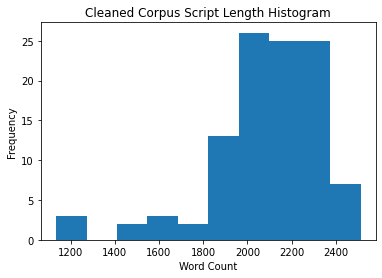

In [1052]:
# histogram of length of documents
df_freq=df_eda
df_eda['totalwords'] = df_eda['text'].str.split().str.len()
plt.title("Cleaned Corpus Script Length Histogram")
plt.ylabel("Frequency")
plt.xlabel("Word Count")
plt.hist(df_eda['totalwords'])

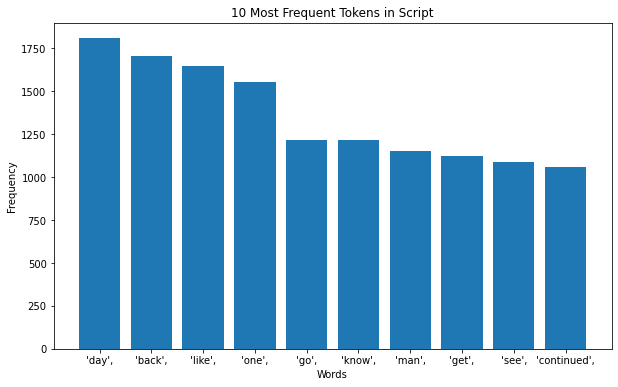

In [1039]:
# #most frequently used text
from matplotlib.pyplot import figure
from collections import Counter

df_freq=df_eda
df_freq['text'] = df_freq['text'].str.strip('[]')
description_list = df_freq['text'].values.tolist()

# counter instance takes 10 most common tokens
word_frequency = Counter(" ".join(description_list).split()).most_common(10)

# return list of word, count tuples
words = [word for word, _ in word_frequency]
counts = [counts for _, counts in word_frequency]

#generate bar plot
figure(figsize = (10, 6))
plt.bar(words, counts)
plt.title("10 Most Frequent Tokens in All Scripts")
plt.ylabel("Frequency")
plt.xlabel("Words")
plt.show()

C:\Users\U6068968\AppData\Local\Temp\ipykernel_19168\3483324301.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_freq['text'] = df_freq['text'].str.strip('[]')


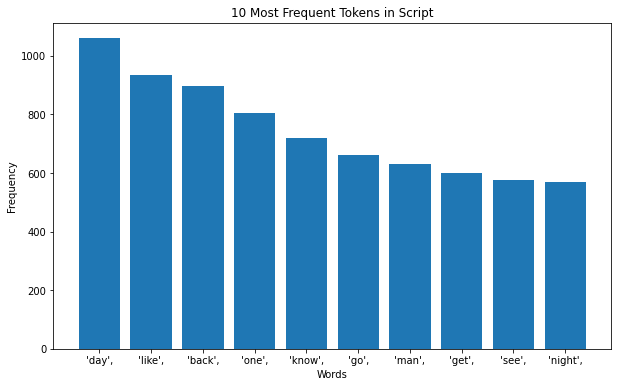

In [1040]:
#most frequently used text in oscar titles

df_freq=df_oscar
df_freq['text'] = df_freq['text'].str.strip('[]')
description_list = df_freq['text'].values.tolist()

# counter instance takes 10 most common tokens
word_frequency = Counter(" ".join(description_list).split()).most_common(10)

# return list of word, count tuples
words = [word for word, _ in word_frequency]
counts = [counts for _, counts in word_frequency]

#generate bar plot
figure(figsize = (10, 6))
plt.bar(words, counts)
plt.title("10 Most Frequent Tokens in Oscar Scripts")
plt.ylabel("Frequency")
plt.xlabel("Words")
plt.show()

C:\Users\U6068968\AppData\Local\Temp\ipykernel_19168\26236295.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_freq['text'] = df_freq['text'].str.strip('[]')


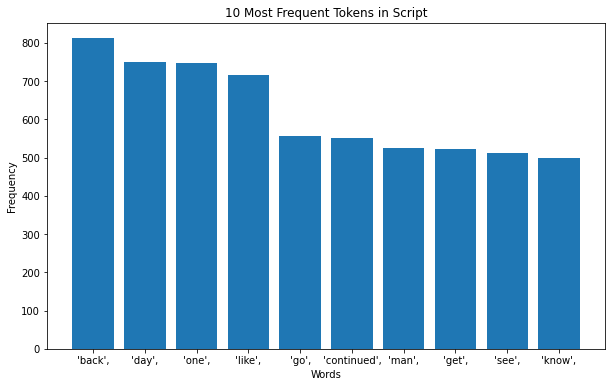

In [1041]:
#most frequently used text in non-oscar titles

df_freq=df_unremark
df_freq['text'] = df_freq['text'].str.strip('[]')
description_list = df_freq['text'].values.tolist()

# counter instance takes 10 most common tokens
word_frequency = Counter(" ".join(description_list).split()).most_common(10)

# return list of word, count tuples
words = [word for word, _ in word_frequency]
counts = [counts for _, counts in word_frequency]

#generate bar plot
figure(figsize = (10, 6))
plt.bar(words, counts)
plt.title("10 Most Frequent Tokens in Unremarkable Scripts")
plt.ylabel("Frequency")
plt.xlabel("Words")
plt.show()

In [ ]:
#relative emotion scores for oscar movies

In [ ]:
#relative emotion scores for oscar movies

In [1025]:
raise SystemExit("Stop right there!") 

SystemExit: Stop right there!

C:\Users\U6068968\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3560: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# model pre-processing

df = response_df_merged.astype(str)

# store titles
titles = df["title"]

# fit transform target variable
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(df["label"]).ravel()

# keep feature cols
X = df[
    [
        "text",
        "anger",
        "anticipation",
        "disgust",
        "fear",
        "joy",
        "negative",
        "positive",
        "sadness",
        "surprise",
        "trust",
    ]
]

# list of features cols
feature_list = list(X.columns)

# train test split and holdout validation
# stratify=y argument could not be applied

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
)

# Encoding text features to numerical matrices
column_trans = ColumnTransformer(
    [("columns", TfidfVectorizer(), "text")],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

X_train = column_trans.fit_transform(X_train)
X_test = column_trans.transform(X_test)
X_val = column_trans.transform(X_val)

In [ ]:
# baseline modeling

# instantiate algorithms
rf = RandomForestClassifier()
lr = LogisticRegression()
svm = SVC(probability=True)

# checking the intitial f1 score of each classifier on the test set
for algorithm in (rf, lr, svm):
    algorithm.fit(X_train, y_train)
    y_pred = algorithm.predict(X_test)
    print("%.2f" % f1_score(y_test, y_pred, average="micro"))

In [ ]:
# GridSearchCV for parameter tuning

param_grid = {
    "n_estimators": [50, 125, 150, 175, 200],
    "max_depth": [50, 75, 100, 125, 400],
}
grid = GridSearchCV(rf, param_grid, refit=True, verbose=1)
grid.fit(X_train, y_train)
print(grid.best_estimator_)

In [ ]:
# predicting on test
y_hat_test = rf.predict(X_test)

In [ ]:
# predicting on holdout validation
y_hat = rf.predict(X_val)
print("%.2f" % f1_score(y_val, y_hat, average="micro"))

In [ ]:
print(classification_report(y_hat_test, y_pred))

In [ ]:
print(classification_report(y_val, y_hat))

In [ ]:
#ROC Curve
y_pred_proba = rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="RandomForest ROC, auc="+str("%.2f" % auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
# ensuring PEP8 compliance with nbQA
# run nbqa flake8 A3_Jagraj_Gill.ipynb
# nbqa black A3_Jagraj_Gill.ipynb
# nbqa isort my_notebook.ipynb
# in command line